In [ ]:

!pip uninstall -y torch torchvision torchaudio -q
!pip install -q --index-url https://download.pytorch.org/whl/cu126 \
  torch==2.8.0 torchvision==0.23.0 torchaudio==2.8.0
!pip install -q --no-deps transformers librosa soundfile
!pip install -q seaborn==0.13.2 joblib==1.4.2 scikit-learn==1.6.1 umap-learn==0.5.9.post2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.8/821.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 12.6 MB/s eta 0:00:00


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

import os, gc, subprocess, shlex, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

ROOT      = "/content/drive/MyDrive/speechproject"
WORK_DIR  = f"{ROOT}/workspace"
DATA_DIR  = f"{WORK_DIR}/IndicAccentDb_raw"
META_DIR  = f"{WORK_DIR}/metadata"
FEAT_DIR  = f"{WORK_DIR}/feat_cache/hubert_base"
MODEL_DIR = f"{WORK_DIR}/models"
for p in [WORK_DIR, DATA_DIR, META_DIR, FEAT_DIR, MODEL_DIR]:
    Path(p).mkdir(parents=True, exist_ok=True)

print("DATA_DIR :", DATA_DIR)
print("META_DIR :", META_DIR)
print("FEAT_DIR :", FEAT_DIR)
print("MODEL_DIR:", MODEL_DIR)


ZIP_PATH = f"{ROOT}/IndicAccentDB.zip"
if not any(Path(DATA_DIR).glob("*.wav")):
    import zipfile
    assert Path(ZIP_PATH).exists(), f"ZIP not found at {ZIP_PATH}"
    with zipfile.ZipFile(ZIP_PATH, "r") as zf:
        zf.extractall(DATA_DIR)
    print("[done] Dataset extracted.")
else:
    print("[skip] Using existing extracted dataset.")

Mounted at /content/drive
DATA_DIR : /content/drive/MyDrive/speechproject/workspace/IndicAccentDb_raw
META_DIR : /content/drive/MyDrive/speechproject/workspace/metadata
FEAT_DIR : /content/drive/MyDrive/speechproject/workspace/feat_cache/hubert_base
MODEL_DIR: /content/drive/MyDrive/speechproject/workspace/models


In [ ]:

AUDIO_EXTS = {".wav", ".flac", ".mp3", ".m4a", ".ogg"}
all_audio = [p for p in Path(DATA_DIR).rglob("*") if p.suffix.lower() in AUDIO_EXTS]
print("Total audio files found:", len(all_audio))
assert len(all_audio) > 0, "No audio files found."

rel_paths = [str(p.relative_to(DATA_DIR)) for p in all_audio]
labels    = [Path(r).parts[0] for r in rel_paths]
df = pd.DataFrame({"file_path": rel_paths, "label": labels})
CSV_PATH = str(Path(META_DIR) / "samples.csv")
df.to_csv(CSV_PATH, index=False)
print("Saved:", CSV_PATH)
display(df.head())


Total audio files found: 8116
Saved: /content/drive/MyDrive/speechproject/workspace/metadata/samples.csv


,file_path,label
0,andhra_pradesh/Andhra_speaker (1717).wav,andhra_pradesh
1,andhra_pradesh/Andhra_speaker (1718).wav,andhra_pradesh
2,andhra_pradesh/Andhra_speaker (1719).wav,andhra_pradesh
3,andhra_pradesh/Andhra_speaker (172).wav,andhra_pradesh
4,andhra_pradesh/Andhra_speaker (1720).wav,andhra_pradesh


In [ ]:

import librosa, soundfile as sf, torchaudio

SR = 16000
SEG_SEC = 3.0
FMIN, FMAX = 70, 500

BADLIST_PATH = Path(META_DIR) / "bad_audio_paths.txt"
CONVERT_LOG  = Path(META_DIR) / "converted_audio_paths.txt"
BADLIST_PATH.unlink(missing_ok=True)
CONVERT_LOG.unlink(missing_ok=True)

def _ffmpeg_convert_to_wav16k(src_path: str) -> str | None:
    out = Path(src_path).with_suffix(".clean16k.wav")
    cmd = f'ffmpeg -y -v error -i {shlex.quote(src_path)} -ac 1 -ar {SR} {shlex.quote(str(out))}'
    try:
        subprocess.run(cmd, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        with open(CONVERT_LOG, "a") as f:
            f.write(str(out) + "\n")
        return str(out)
    except subprocess.CalledProcessError:
        return None

def robust_load_audio(path: str, sr: int = SR):
    p = Path(path)

    try:
        y, native_sr = sf.read(str(p), always_2d=False)
        if y is not None and y.size > 0:
            if native_sr != sr:
                y = librosa.resample(y.astype(np.float32), orig_sr=native_sr, target_sr=sr)
            if y.ndim > 1: y = y.mean(axis=1)
            return y.astype(np.float32), sr
    except: pass

    try:
        y, _sr = librosa.load(str(p), sr=sr, mono=True)
        if y is not None and y.size > 0: return y.astype(np.float32), sr
    except: pass

    try:
        wav, _sr = torchaudio.load(str(p))
        if wav.shape[0] > 1: wav = wav.mean(dim=0, keepdim=True)
        if _sr != sr:
            resampler = torchaudio.transforms.Resample(orig_freq=_sr, new_freq=sr)
            wav = resampler(wav)
        y = wav.squeeze(0).numpy().astype(np.float32)
        return y, sr
    except: pass

    converted = _ffmpeg_convert_to_wav16k(str(p))
    if converted and Path(converted).exists():
        try:
            y, _sr = librosa.load(converted, sr=sr, mono=True)
            if y is not None and y.size > 0:
                return y.astype(np.float32), sr
        except: pass

    with open(BADLIST_PATH, "a") as f:
        f.write(str(p) + "\n")
    return None

def estimate_median_f0(wav_path: str) -> float:
    loaded = robust_load_audio(wav_path, sr=SR)
    if loaded is None: return np.nan
    y, _sr = loaded
    if y.size > int(SEG_SEC * SR):
        y = y[: int(SEG_SEC * SR)]
    f0, _, _ = librosa.pyin(y, fmin=FMIN, fmax=FMAX, sr=SR)
    if f0 is None: return np.nan
    f0 = f0[~np.isnan(f0)]
    return float(np.median(f0)) if f0.size else np.nan

df = pd.read_csv(CSV_PATH)
F0_CACHE  = str(Path(META_DIR) / "f0_median.npy")
IDX_CACHE = str(Path(META_DIR) / "f0_index.npy")

if Path(F0_CACHE).exists() and Path(IDX_CACHE).exists():
    f0_medians = np.load(F0_CACHE)
    f0_index   = np.load(IDX_CACHE)
    if len(f0_index) != len(df):
        print("[warn] F0 cache length mismatch; recomputing.")
        f0_medians = None
else:
    f0_medians = None

if f0_medians is None:
    f0_medians = np.empty(len(df), dtype=np.float32)
    for i, rel in enumerate(df["file_path"]):
        full = str(Path(DATA_DIR) / rel)
        try:
            f0_medians[i] = estimate_median_f0(full)
        except:
            f0_medians[i] = np.nan
        if (i+1) % 200 == 0:
            gc.collect()
            print(f"[F0] {i+1}/{len(df)}")
    np.save(F0_CACHE, f0_medians); np.save(IDX_CACHE, np.arange(len(df)))
    print("[done] F0 cached.")
df["f0_median_hz"] = f0_medians


from sklearn.mixture import GaussianMixture
valid = df["f0_median_hz"].notna()
log_f0 = np.log(df.loc[valid, "f0_median_hz"].values.reshape(-1,1))
gmm = GaussianMixture(n_components=3, random_state=42).fit(log_f0)
cid = gmm.predict(log_f0)
means_hz = np.exp(gmm.means_).ravel()
order = np.argsort(means_hz)
cluster_to_group = {order[0]:"male", order[1]:"female", order[2]:"child"}
df.loc[valid, "age_group_gmm"] = [cluster_to_group[int(c)] for c in cid]
print("GMM cluster means (Hz) low->high:", np.sort(means_hz))

GMM cluster means (Hz) low->high: [147.67034181 222.90386105 255.51398623]


In [ ]:

from sklearn.model_selection import train_test_split

TEST_SAMPLES_PER_LABEL = 20

labels_sorted = sorted(df["label"].unique().tolist())
test_indices, remain_indices = [], []

for lab in labels_sorted:
    sub = df[df["label"] == lab]
    n_test = min(TEST_SAMPLES_PER_LABEL, max(1, len(sub)//2))
    test_rows = sub.sample(n=n_test, random_state=42)
    test_indices.extend(test_rows.index.tolist())
    remain_indices.extend(sub.drop(test_rows.index).index.tolist())

df["split"] = "train_val"
df.loc[test_indices, "split"] = "test"

train_val_df = df[df["split"] == "train_val"]
train_df, val_df = train_test_split(
    train_val_df, test_size=0.2, stratify=train_val_df["label"], random_state=42
)
df.loc[train_df.index, "split"] = "train"
df.loc[val_df.index,   "split"] = "val"

print("\nSplit counts:\n", df["split"].value_counts())
print("\nLabel distribution in TEST:\n", df[df["split"]=="test"]["label"].value_counts().sort_index())

CSV_BAL = str(Path(META_DIR) / "samples_balanced.csv")
df.to_csv(CSV_BAL, index=False)
print("\n✅ Balanced split CSV saved ->", CSV_BAL)



Split counts:
 split
train    6396
val      1600
test      120
Name: count, dtype: int64

Label distribution in TEST:
 label
andhra_pradesh    20
gujrat            20
jharkhand         20
karnataka         20
kerala            20
tamil             20
Name: count, dtype: int64

✅ Balanced split CSV saved -> /content/drive/MyDrive/speechproject/workspace/metadata/samples_balanced.csv


In [ ]:

import torch
from transformers import AutoFeatureExtractor, HubertModel

df_use = pd.read_csv(CSV_BAL)
df_use = df_use[df_use["split"].isin(["train","val","test"])].copy()

MODEL_NAME = "facebook/hubert-base-ls960"
SR = 16000
MAX_SEC = 12.0

extractor = AutoFeatureExtractor.from_pretrained(MODEL_NAME)
model = HubertModel.from_pretrained(MODEL_NAME)
model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"HuBERT model loaded on {device}")

def out_path_for(rel_path: str, split: str, label: str, layer_idx: int) -> Path:
    stem = Path(rel_path).stem
    layer_dir = Path(FEAT_DIR) / f"layer_{layer_idx}" / split / label
    layer_dir.mkdir(parents=True, exist_ok=True)
    return layer_dir / f"{stem}.npy"

@torch.inference_mode()
def extract_and_cache_one(rel_path: str, split: str, label: str) -> bool:
    p0 = out_path_for(rel_path, split, label, layer_idx=0)
    if p0.exists(): return False
    full = str(Path(DATA_DIR) / rel_path)
    loaded = robust_load_audio(full, sr=SR)
    if loaded is None: return False
    y, _sr = loaded
    if y.size > int(MAX_SEC * SR): y = y[: int(MAX_SEC * SR)]
    y = y / (np.max(np.abs(y)) + 1e-8)
    inputs = extractor(y, sampling_rate=SR, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    out = model(**inputs, output_hidden_states=True)
    hss = out.hidden_states
    for i, hs in enumerate(hss):
        vec = torch.mean(hs, dim=1).squeeze(0).detach().cpu().numpy().astype("float32")
        np.save(out_path_for(rel_path, split, label, i), vec)
    del out, hss, inputs
    if device == "cuda": torch.cuda.empty_cache()
    gc.collect()
    return True

subset = df_use.head(10)
done = 0
for _, r in subset.iterrows():
    done += int(extract_and_cache_one(r["file_path"], r["split"], r["label"]))
print(f"[dry-run] Newly processed: {done}/{len(subset)}")

total = len(df_use); processed = 0
for idx, r in df_use.iterrows():
    processed += int(extract_and_cache_one(r["file_path"], r["split"], r["label"]))
    if (idx+1) % 200 == 0:
        print(f"[progress] {idx+1}/{total} scanned, {processed} newly cached")
        gc.collect()
print(f"[done] HuBERT caching complete. New files: {processed}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

HuBERT model loaded on cpu
[dry-run] Newly processed: 0/10
[progress] 200/8116 scanned, 14 newly cached
[progress] 400/8116 scanned, 31 newly cached
[progress] 600/8116 scanned, 51 newly cached
[progress] 800/8116 scanned, 74 newly cached
[progress] 1000/8116 scanned, 90 newly cached
[progress] 1200/8116 scanned, 108 newly cached
[progress] 1400/8116 scanned, 121 newly cached
[progress] 1600/8116 scanned, 153 newly cached
[progress] 1800/8116 scanned, 169 newly cached
[progress] 2000/8116 scanned, 193 newly cached
[progress] 2200/8116 scanned, 205 newly cached
[progress] 2400/8116 scanned, 219 newly cached
[progress] 2600/8116 scanned, 259 newly cached
[progress] 2800/8116 scanned, 305 newly cached
[progress] 3000/8116 scanned, 338 newly cached
[progress] 3200/8116 scanned, 365 newly cached
[progress] 3400/8116 scanned, 390 newly cached
[progress] 3600/8116 scanned, 416 newly cached
[progress] 3800/8116 scanned, 442 newly cached
[progress] 4000/8116 scanned, 475 newly cached
[progress]

In [ ]:

from pathlib import Path
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import joblib, json, matplotlib.pyplot as plt

CSV_BAL = str(Path(META_DIR) / "samples_balanced.csv")
df_use = pd.read_csv(CSV_BAL)
df_use = df_use[df_use["split"].isin(["train","val","test"])].copy()
labels_sorted = sorted(df_use["label"].unique().tolist())
le = LabelEncoder().fit(labels_sorted)

In [ ]:

def stack_split(layer, split):
    """Stack all .npy for this layer/split into one .npz"""
    out_path = Path(FEAT_DIR)/f"mat_{layer}_{split}.npz"
    if out_path.exists():
        return
    X, y = [], []
    sdf = df_use[df_use["split"]==split]
    for _, r in sdf.iterrows():
        p = Path(FEAT_DIR)/f"layer_{layer}"/r["split"]/r["label"]/(Path(r["file_path"]).stem+".npy")
        if p.exists():
            X.append(np.load(p))
            y.append(r["label"])
    if not X:
        print(f"⚠️ No files found for layer {layer} split {split}")
        return
    np.savez_compressed(out_path, X=np.stack(X), y=np.array(y))
    print(f"[stacked] layer {layer} {split}: {len(y)} samples → {out_path.name}")

for layer in range(13):
    for split in ["train","val","test"]:
        stack_split(layer, split)

[stacked] layer 12 val: 1600 samples → mat_12_val.npz
[stacked] layer 12 test: 120 samples → mat_12_test.npz


In [ ]:

best_layer, best_val = None, -1.0
layer_scalers = {}

for layer in range(13):
    dat_tr = np.load(Path(FEAT_DIR)/f"mat_{layer}_train.npz")
    dat_va = np.load(Path(FEAT_DIR)/f"mat_{layer}_val.npz")

    Xtr, ytr = dat_tr["X"], le.transform(dat_tr["y"])
    Xva, yva = dat_va["X"], le.transform(dat_va["y"])

    scaler = StandardScaler().fit(Xtr)
    Xtr_s, Xva_s = scaler.transform(Xtr), scaler.transform(Xva)
    clf = LogisticRegression(max_iter=800)
    clf.fit(Xtr_s, ytr)
    acc = accuracy_score(yva, clf.predict(Xva_s))
    print(f"[LAYER {layer:2}] VAL={acc:.4f}")
    if acc > best_val:
        best_val, best_layer = acc, layer
        layer_scalers[layer] = scaler

print(f"\n✅ Best layer = {best_layer} (VAL={best_val:.4f})")

[LAYER  0] VAL=0.9625
[LAYER  1] VAL=0.9775
[LAYER  2] VAL=0.9794
[LAYER  3] VAL=0.9656
[LAYER  4] VAL=0.9656
[LAYER  5] VAL=0.9600
[LAYER  6] VAL=0.9487
[LAYER  7] VAL=0.9169
[LAYER  8] VAL=0.9175
[LAYER  9] VAL=0.9038
[LAYER 10] VAL=0.9250
[LAYER 11] VAL=0.9244
[LAYER 12] VAL=0.9331

✅ Best layer = 2 (VAL=0.9794)


In [ ]:

dat_tr = np.load(Path(FEAT_DIR)/f"mat_{best_layer}_train.npz")
dat_va = np.load(Path(FEAT_DIR)/f"mat_{best_layer}_val.npz")
dat_te = np.load(Path(FEAT_DIR)/f"mat_{best_layer}_test.npz")

Xtr, ytr = dat_tr["X"], le.transform(dat_tr["y"])
Xva, yva = dat_va["X"], le.transform(dat_va["y"])
Xte, yte = dat_te["X"], le.transform(dat_te["y"])

scaler = StandardScaler().fit(Xtr)
Xtr_s, Xva_s, Xte_s = scaler.transform(Xtr), scaler.transform(Xva), scaler.transform(Xte)

Cs = [0.5, 1.0, 2.0]
best_c, best_val_svm, best_model = None, -1.0, None
for C in Cs:
    svm = Pipeline([("clf", LinearSVC(C=C))])
    svm.fit(Xtr_s, ytr)
    val_acc = accuracy_score(yva, svm.predict(Xva_s))
    print(f"[VAL] LinearSVC C={C}: {val_acc:.4f}")
    if val_acc > best_val_svm:
        best_val_svm, best_c, best_model = val_acc, C, svm

print(f"\nChosen LinearSVC C={best_c} (VAL={best_val_svm:.4f}) — layer {best_layer}")

[VAL] LinearSVC C=0.5: 0.9862
[VAL] LinearSVC C=1.0: 0.9862
[VAL] LinearSVC C=2.0: 0.9881

Chosen LinearSVC C=2.0 (VAL=0.9881) — layer 2



=== TEST (balanced) — LinearSVC — Layer 2 ===
Accuracy: 0.9833

                precision    recall  f1-score   support

andhra_pradesh     1.0000    0.9500    0.9744        20
        gujrat     1.0000    0.9500    0.9744        20
     jharkhand     1.0000    1.0000    1.0000        20
     karnataka     1.0000    1.0000    1.0000        20
        kerala     1.0000    1.0000    1.0000        20
         tamil     0.9091    1.0000    0.9524        20

      accuracy                         0.9833       120
     macro avg     0.9848    0.9833    0.9835       120
  weighted avg     0.9848    0.9833    0.9835       120



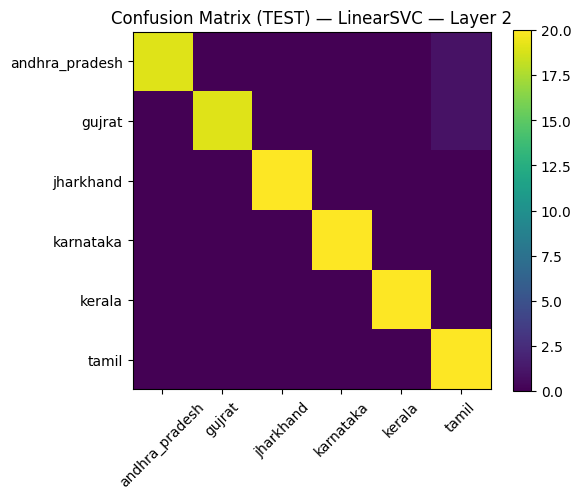

In [ ]:

pred_te = best_model.predict(Xte_s)
test_acc = accuracy_score(yte, pred_te)
print(f"\n=== TEST (balanced) — LinearSVC — Layer {best_layer} ===")
print(f"Accuracy: {test_acc:.4f}\n")
print(classification_report(yte, pred_te, target_names=labels_sorted, digits=4, zero_division=0))

cm = confusion_matrix(yte, pred_te, labels=np.arange(len(labels_sorted)))
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title(f'Confusion Matrix (TEST) — LinearSVC — Layer {best_layer}')
plt.colorbar()
plt.xticks(range(len(labels_sorted)), labels_sorted, rotation=45)
plt.yticks(range(len(labels_sorted)), labels_sorted)
plt.tight_layout()
plt.show()

In [ ]:
# --------------------------------------------------------------
# STEP 5. Save model artifacts
# --------------------------------------------------------------
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)
joblib.dump(best_model,        Path(MODEL_DIR)/"accent_clf_latest.pkl")
joblib.dump(scaler,            Path(MODEL_DIR)/"accent_scaler_latest.pkl")
joblib.dump(le,                Path(MODEL_DIR)/"accent_label_encoder_latest.pkl")

cfg = {
    "hubert_model": "facebook/hubert-base-ls960",
    "best_layer": int(best_layer),
    "labels": labels_sorted,
    "split_csv": CSV_BAL,
    "chosen_model": "LinearSVC",
    "C": best_c,
    "notes": "13-layer sweep using stacked .npz (fast I/O)"
}
json.dump(cfg, open(Path(MODEL_DIR)/"config.json","w"))
print("\nSaved model artifacts to:", MODEL_DIR)


Saved model artifacts to: /content/drive/MyDrive/speechproject/workspace/models
